# Models

In [109]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [110]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data.csv')


#### Filterout the paper described patient set

In [111]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [112]:

# def get_missing_row_val_percentage(df):
#     df['new'] = df.isnull().sum(axis=1)
#     return df


# df = get_missing_row_val_percentage(df)

# filter_patients = df[(df["new"] >= 85)] 
# filter_patients.PtID.size

### for SH events prediction pre processing


In [113]:
y_label = 'Pt_SevHypoEver' 
# possible labels Pt_SevHypoEver, SHSeizComaPast12mos, DKAPast12mos, Depression, DiabNeuro, DKADiag

In [114]:
df[y_label].unique()

array([ 1.,  0., nan,  2.])

In [115]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

get_possible_vals_with_nan(df, y_label)

if(y_label == 'SHSeizComaPast12mos' ):
    df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa','NumSHSeizComa', 'Pt_SevHypoEver'], inplace=True, axis=1) # add SHSeizComaPast12mos
    df[y_label] = df[y_label].replace({2.0: 1.0})

elif (y_label == 'DKADiag'):  # DKADiag {'1.Yes': 0, '2.Probably Yes': 1, '3.No': 2, '4.Unknown': 3}
    df.drop(['Pt_NumHospDKA','Pt_HospDKASinceDiag','NumDKAOccur', 'DKAPast12mos'], inplace=True, axis=1)
    df[y_label] = df[y_label].replace({1.0: 0, 2: 1, 3: 1 })
    
elif (y_label == 'Pt_SevHypoEver'):
    df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa','NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1) # add SHSeizComaPast12mos
    df[y_label] = df[y_label].replace({2.0: 1.0})

elif (y_label == 'DKAPast12mos'):
    df.drop(['Pt_NumHospDKA','Pt_HospDKASinceDiag','NumDKAOccur', 'DKADiag'], inplace=True, axis=1)
    df[y_label] = df[y_label].replace({2.0: 1.0})

# f_df = df[df['Pt_SevHypoEver'] == 0.0]
# f_df.PtID.size

# f2_df = df[df['Pt_SevHypoEver'] == 1.0]
# f2_df.PtID.size

In [116]:
# df.columns.to_numpy()

df[y_label].isna().sum()

2080

# Divide Dataset

In [117]:
# filter only the features used in paper diagDuration,

selected_features = True

if(selected_features):
    df = df[['AgeAtConsent','diagDuration','HbA1c', 'Gender', 'Pt_RaceEth','Pt_AnnualInc', 'Pt_InsPriv', 'Pt_EduLevel',
         'InsulinDeliv','Pt_InsCarbRat', 'relative_T1D', 'Pt_Smoke', y_label,
         'MajorLifeStressEvent', 'Weight', 'Height']] # Pt_SevHypoEver ,SHSeizComaPast12mos, DKAPast12mos


In [118]:
if(!selected_features):
    df.drop('PtID', axis = 1)

In [119]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y


X, Y = divide_data(df, y_label)


# Correlation

In [120]:
# # Correlation
# X = pd.DataFrame(X)
# corr = X.corr(method ='pearson')

# corr = X.corr(method ='pearson').abs()
# # avg_corr = corr.mean(axis = 1)


In [121]:
# import seaborn as sn
# plt.figure(figsize=(20,20))

# sn.heatmap(corr,annot=True)
# plt.title('Correlation Matrix', fontsize=16)
# plt.show()

# Feature Selection

In [122]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

In [123]:
shape = np.shape(X) 
feature = shape[1] 
n_classes = 2

feature

15

In [124]:

# fill with 0 - if data not available probably patient has not that medical condition
if(y_label == 'SHSeizComaPast12mos' or y_label == 'DKADiag' or y_label == 'Pt_SevHypoEver' or y_label == 'DKAPast12mos'):
    Y = Y.fillna(1)
else:
    Y = Y.fillna(0)


In [125]:

seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)
# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [126]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print(unique, counts)


unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print(unique_test, counts_test)


[0. 1.] [1471 3895]
[0. 1.] [ 491 1298]


## Model 1 - XGB - With missing data

72.55449972051426
              precision    recall  f1-score   support

         0.0       0.50      0.09      0.15       491
         1.0       0.74      0.97      0.84      1298

    accuracy                           0.73      1789
   macro avg       0.62      0.53      0.49      1789
weighted avg       0.67      0.73      0.65      1789



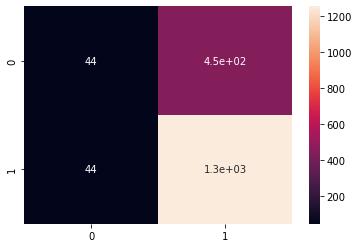

In [127]:
# xgboost - train with missing values
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model=XGBClassifier(use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 3, #values between(3-10)
        max_delta_step = 1,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 0.7,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
        min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes)
model.fit(X_train,Y_train)



xgb_pred=model.predict(X_test)
print(accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = pd.DataFrame(confusion_matrix(Y_test, xgb_pred))
sns.heatmap(confusion_matrix_xgb, annot=True)
print(classification_report(Y_test, xgb_pred))

# Imputations

In [128]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
# imputeX = IterativeImputer(max_iter=5, random_state=0)

X_train = imputeX.fit_transform(X_train)


In [129]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)


# Scale data

In [130]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))

# Feature selection

In [131]:
# TODO

def select_features(select, feature):
    selected = {}
    fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx



In [132]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
# def select_features(select, feature):
#     selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 10) #  step (the number of features eliminated each iteration) 
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx


In [133]:
# Feature selection
selected, fs, idx = select_features(select, feature)
X_train = pd.DataFrame(selected[0])
X_test = pd.DataFrame(selected[1])

In [134]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)

Index(['AgeAtConsent', 'diagDuration', 'HbA1c', 'Gender', 'Pt_RaceEth',
       'Pt_AnnualInc', 'Pt_InsPriv', 'Pt_EduLevel', 'InsulinDeliv',
       'Pt_InsCarbRat', 'relative_T1D', 'Pt_Smoke', 'MajorLifeStressEvent',
       'Weight', 'Height'],
      dtype='object')
(7155, 15)


## AdaBoost

In [135]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm

C = [0.1,1.0,10.0,100.0]
gamma = [0.1,0.25,0.5,0.75,1.0,2.0]
n_estimators = [50,100,500,1000]
learning_rate = [0.1,0.25,0.5,0.75,1.0]

adaBoost_parameters = {'learning_rate': learning_rate,'n_estimators':n_estimators }
ada_model = AdaBoostClassifier(random_state=0)
adaBoost = GridSearchCV(ada_model, adaBoost_parameters, cv=10)

In [136]:
adaBoost.fit(X_train,Y_train)
ada_best_params_acc = adaBoost.best_params_
print('Best hyperparameters for AdaBoost training acc :', ada_best_params_acc)

Best hyperparameters for AdaBoost training acc : {'learning_rate': 0.25, 'n_estimators': 500}


72.61039686975964
              precision    recall  f1-score   support

         0.0       0.51      0.10      0.17       491
         1.0       0.74      0.96      0.84      1298

    accuracy                           0.73      1789
   macro avg       0.62      0.53      0.50      1789
weighted avg       0.67      0.73      0.65      1789



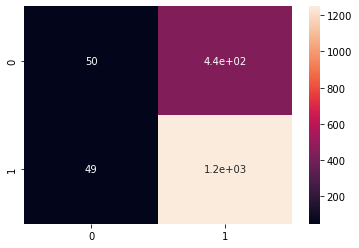

In [137]:
adaBoost_best_acc = AdaBoostClassifier(random_state=0, learning_rate=ada_best_params_acc['learning_rate'], n_estimators=ada_best_params_acc['n_estimators'] )
adaBoost_best_acc.fit(X_train, Y_train)

pred=adaBoost_best_acc.predict(X_test)
print(accuracy_score(Y_test, pred)*100)

confusion_matrix_xgb = pd.DataFrame(confusion_matrix(Y_test, pred))
sns.heatmap(confusion_matrix_xgb, annot=True)
print(classification_report(Y_test, pred))

# Model - XGB

72.10732252655114
              precision    recall  f1-score   support

         0.0       0.48      0.17      0.25       491
         1.0       0.75      0.93      0.83      1298

    accuracy                           0.72      1789
   macro avg       0.61      0.55      0.54      1789
weighted avg       0.67      0.72      0.67      1789



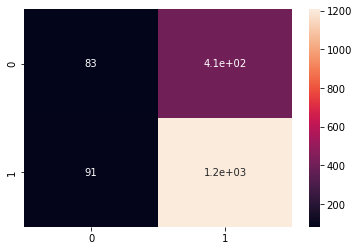

In [138]:
# xgboost - train with missing values
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model=XGBClassifier(use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 9, #values between(3-10)
        max_delta_step = 3,
        subsample = 0.9,#values between(0.5-1)
        colsample_bytree = 0.7,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
        min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes)
model.fit(X_train,Y_train)



xgb_pred=model.predict(X_test)
print(accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = pd.DataFrame(confusion_matrix(Y_test, xgb_pred))
sns.heatmap(confusion_matrix_xgb, annot=True)
print(classification_report(Y_test, xgb_pred))

<AxesSubplot:>

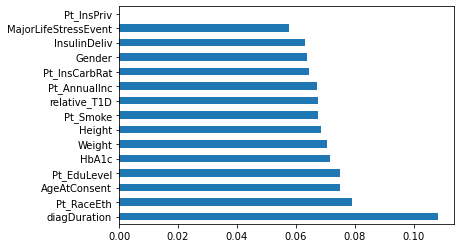

In [139]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

72.55449972051426
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       491
         1.0       0.73      1.00      0.84      1298

    accuracy                           0.73      1789
   macro avg       0.36      0.50      0.42      1789
weighted avg       0.53      0.73      0.61      1789

Accuracy of random forest classifier on training set: 0.73
Accuracy of random forest classifier classifier on test set: 0.73


/home/kali/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kali/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kali/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


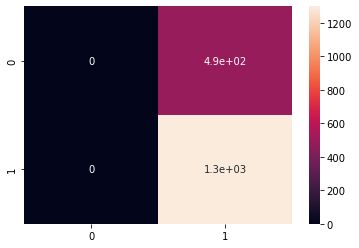

In [140]:
#  random forest classifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


model=RandomForestClassifier(max_depth=5, random_state=0)


model.fit(X_train,Y_train)


pred=model.predict(X_test)
print(accuracy_score(Y_test, pred)*100)

confusion_matrix_rf = pd.DataFrame(confusion_matrix(Y_test, pred))
sns.heatmap(confusion_matrix_rf, annot=True)
print(classification_report(Y_test, pred))

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(model.score(X_train, Y_train)))
print('Accuracy of random forest classifier classifier on test set: {:.2f}'
     .format(model.score(X_test, Y_test)))

<AxesSubplot:>

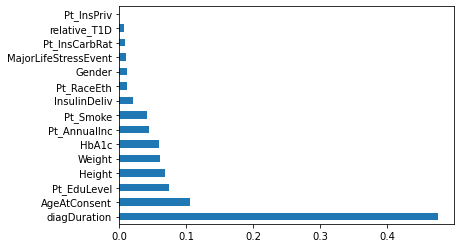

In [141]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 3 LogisticRegression

62.82839575181666
              precision    recall  f1-score   support

         0.0       0.39      0.64      0.48       491
         1.0       0.82      0.63      0.71      1298

    accuracy                           0.63      1789
   macro avg       0.61      0.63      0.60      1789
weighted avg       0.70      0.63      0.65      1789

Accuracy of logistic regression on training set: 0.63
Accuracy of logistic regression on test set: 0.63


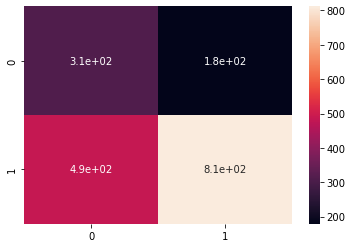

In [142]:
from sklearn.linear_model import LogisticRegression

#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 0.5e-3,
    C=2,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)
logreg.fit(X_train, Y_train)


pred=logreg.predict(X_test)
print(accuracy_score(Y_test, pred)*100)

confusion_matrix_lr = pd.DataFrame(confusion_matrix(Y_test, pred))
sns.heatmap(confusion_matrix_lr, annot=True)
print(classification_report(Y_test, pred))


print('Accuracy of logistic regression on training set: {:.2f}'
     .format(logreg.score(X_train, Y_train)))
print('Accuracy of logistic regression on test set: {:.2f}'
     .format(logreg.score(X_test, Y_test)))



<AxesSubplot:>

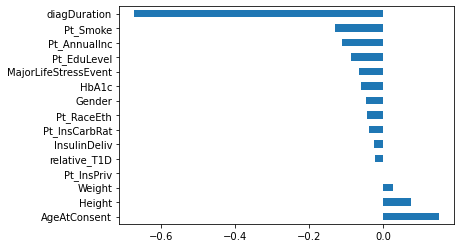

In [143]:

feat_importances = pd.Series(logreg.coef_[0], index=X.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 4 - Decision tree

69.8155394074902
              precision    recall  f1-score   support

         0.0       0.40      0.20      0.27       491
         1.0       0.75      0.89      0.81      1298

    accuracy                           0.70      1789
   macro avg       0.57      0.54      0.54      1789
weighted avg       0.65      0.70      0.66      1789

Accuracy of DT on training set: 0.80
Accuracy of DT on test set: 0.70


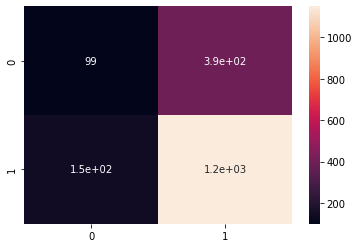

In [144]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(
                        random_state=42,
                        criterion='entropy',
                        splitter = 'best',
                        max_depth = 10,
                        max_features = 15).fit(X_train, Y_train)


pred=clf.predict(X_test)
print(accuracy_score(Y_test, pred)*100)

confusion_matrix_dt = pd.DataFrame(confusion_matrix(Y_test, pred))
sns.heatmap(confusion_matrix_dt, annot=True)
print(classification_report(Y_test, pred))

print('Accuracy of DT on training set: {:.2f}'
     .format(clf.score(X_train, Y_train)))
print('Accuracy of DT on test set: {:.2f}'
     .format(clf.score(X_test, Y_test)))



<AxesSubplot:>

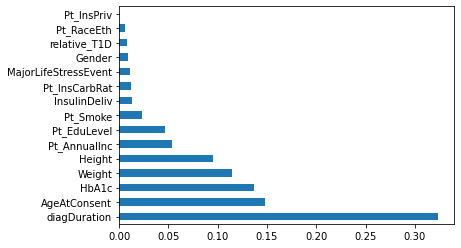

In [145]:

feat_importances = pd.Series(clf.feature_importances_, index=X.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 5 - K-Nearest Neighbors

62.49301285634432
              precision    recall  f1-score   support

         0.0       0.31      0.31      0.31       491
         1.0       0.74      0.74      0.74      1298

    accuracy                           0.62      1789
   macro avg       0.53      0.53      0.53      1789
weighted avg       0.62      0.62      0.62      1789

Accuracy of KNN on training set: 1.00
Accuracy of KNN on test set: 0.62


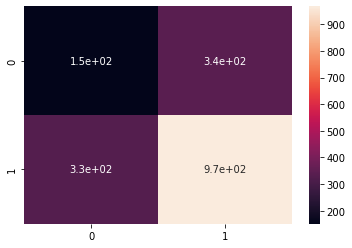

In [146]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(
    n_neighbors =1,
    weights = "distance", # uniform, distance
    algorithm =  'kd_tree', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
)
knn.fit(X_train, Y_train)


pred=knn.predict(X_test)
print(accuracy_score(Y_test, pred)*100)

confusion_matrix_knn = pd.DataFrame(confusion_matrix(Y_test, pred))
sns.heatmap(confusion_matrix_knn, annot=True)
print(classification_report(Y_test, pred))

print('Accuracy of KNN on training set: {:.2f}'
     .format(knn.score(X_train, Y_train)))
print('Accuracy of KNN on test set: {:.2f}'
     .format(knn.score(X_test, Y_test)))

## Model 6 - Linear Discriminant Analysis

72.66629401900502
              precision    recall  f1-score   support

         0.0       0.51      0.11      0.18       491
         1.0       0.74      0.96      0.84      1298

    accuracy                           0.73      1789
   macro avg       0.62      0.53      0.51      1789
weighted avg       0.68      0.73      0.66      1789

Accuracy of LDA on training set: 0.73
Accuracy of LDA on test set: 0.73


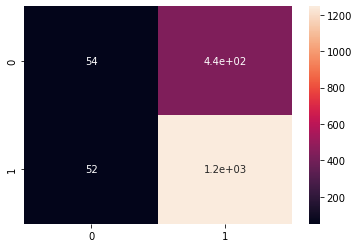

In [147]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 0.3, #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-1                            
)
lda.fit(X_train, Y_train)


pred=lda.predict(X_test)
print(accuracy_score(Y_test, pred)*100)

confusion_matrix_lda = pd.DataFrame(confusion_matrix(Y_test, pred))
sns.heatmap(confusion_matrix_lda, annot=True)
print(classification_report(Y_test, pred))

print('Accuracy of LDA on training set: {:.2f}'
     .format(lda.score(X_train, Y_train)))
print('Accuracy of LDA on test set: {:.2f}'
     .format(lda.score(X_test, Y_test)))

## Model 7- Gaussian Naive Bayes

70.15092230296254
              precision    recall  f1-score   support

         0.0       0.41      0.21      0.28       491
         1.0       0.75      0.89      0.81      1298

    accuracy                           0.70      1789
   macro avg       0.58      0.55      0.55      1789
weighted avg       0.66      0.70      0.67      1789

Accuracy of gaussian naive bayes on training set: 0.70
Accuracy of gaussian naive bayes on test set: 0.70


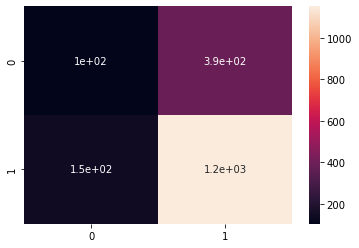

In [148]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)


pred=gnb.predict(X_test)
print(accuracy_score(Y_test, pred)*100)

confusion_matrix_gnb = pd.DataFrame(confusion_matrix(Y_test, pred))
sns.heatmap(confusion_matrix_gnb, annot=True)
print(classification_report(Y_test, pred))

print('Accuracy of gaussian naive bayes on training set: {:.2f}'
     .format(gnb.score(X_train, Y_train)))
print('Accuracy of gaussian naive bayes on test set: {:.2f}'
     .format(gnb.score(X_test, Y_test)))

## Model 8 - SVM

56.679709334823926
              precision    recall  f1-score   support

         0.0       0.25      0.28      0.26       491
         1.0       0.71      0.67      0.69      1298

    accuracy                           0.57      1789
   macro avg       0.48      0.48      0.48      1789
weighted avg       0.58      0.57      0.58      1789

Accuracy ofsvm on training set: 0.56
Accuracy of svm on test set: 0.57


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


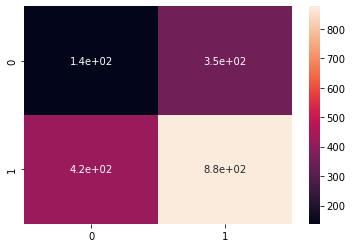

In [149]:
from sklearn.svm import SVC
svm = SVC(
    C = 0.1, # Cfloat, default=1.0
    kernel = 'linear', #kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
    degree = 3, #degree, default=3
    gamma = 0.1, #gamma{‘scale’, ‘auto’} or float, default=’scale’
    class_weight = None, # ‘balanced’, default=None
    max_iter = 8,
    decision_function_shape = 'ovo' # {‘ovo’, ‘ovr’}, default=’ovr’
)

svm.fit(X_train, Y_train)

pred=svm.predict(X_test)
print(accuracy_score(Y_test, pred)*100)

confusion_matrix_svm = pd.DataFrame(confusion_matrix(Y_test, pred))
sns.heatmap(confusion_matrix_svm, annot=True)
print(classification_report(Y_test, pred))


print('Accuracy ofsvm on training set: {:.2f}'
     .format(svm.score(X_train, Y_train)))
print('Accuracy of svm on test set: {:.2f}'
     .format(svm.score(X_test, Y_test)))